In [25]:
import numpy as np
import pandas as pd

In [26]:
# get crime data prior to May 2018
police = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
police=police[['IncidntNum','Category','Y','X','Date', 'PdDistrict']]

In [27]:
police['Year'] = police.Date.str[-4:]
police.columns = ['IncidntNum','Category','lat','lon','Date', 'PdDistrict', 'Year']

In [28]:
# get crime data after May 2018
police2018 = pd.read_csv("/Users/yao/Downloads/Police_Department_Incident_Reports__2018_to_Present.csv")

In [29]:
police2018=police2018[['Incident Number','Incident Category','Latitude','Longitude','Incident Date','Incident Year', 'Police District']]
police2018.columns = ['IncidntNum','Category','lat','lon','Date', 'Year', 'PdDistrict']
police2018 = police2018.loc[police2018.Year==2018]
police2018.head()

,IncidntNum,Category,lat,lon,Date,Year,PdDistrict
0,180908554,Other Miscellaneous,37.784908,-122.404795,2018/12/02,2018,Southern
1,180908112,Lost Property,37.786410,-122.408036,2018/12/01,2018,Central
217,196076472,Larceny Theft,37.766871,-122.416549,2018/11/16,2018,Mission
322,180625134,Larceny Theft,37.777400,-122.407015,2018/08/19,2018,Southern
381,196076290,Larceny Theft,NaN,NaN,2018/12/31,2018,Bayview


In [30]:
police.Year = police.Year.astype(int)
police = police.loc[police.Year.isin([2016,2017,2018])]
police=police[['IncidntNum','Category','lat','lon','Date', 'Year', 'PdDistrict']]
police.head()

,IncidntNum,Category,lat,lon,Date,Year,PdDistrict
0,180362289,VEHICLE THEFT,37.775207,-122.411912,05/15/2018,2018,SOUTHERN
1,180360948,NON-CRIMINAL,37.775146,-122.419258,05/15/2018,2018,SOUTHERN
2,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION
3,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION
4,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION


In [31]:
# combine two data sets to have all records of the last three years
police_all = pd.concat([police,police2018])
police_all = police_all.loc[~police_all.lat.isna()]
police_all.head()

,IncidntNum,Category,lat,lon,Date,Year,PdDistrict
0,180362289,VEHICLE THEFT,37.775207,-122.411912,05/15/2018,2018,SOUTHERN
1,180360948,NON-CRIMINAL,37.775146,-122.419258,05/15/2018,2018,SOUTHERN
2,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION
3,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION
4,180360879,OTHER OFFENSES,37.757101,-122.417813,05/15/2018,2018,MISSION


In [32]:
police_all.shape[0]

499136

In [33]:
def distance(a, b, c, d):
    dis = ((a-c)**2 + (b-d)**2)**(1/2)
    return dis

In [34]:
# getting zipcode coordinates data
zipcode = pd.read_csv("/Users/yao/Downloads/zipcode.csv")
zipcode = zipcode.loc[zipcode.ZIP//1000==94, ['ZIP', 'LAT', 'LNG']]
zipcode.head()

,ZIP,LAT,LNG
30954,94002,37.514352,-122.298896
30955,94005,37.688826,-122.408935
30956,94010,37.570280,-122.365778
30957,94014,37.690884,-122.447441
30958,94015,37.681264,-122.480589


In [35]:
policelist = []
for index, row in police_all.iterrows():
    policelist.append((index, row['IncidntNum'], row['Category'], row['lat'], row['lon'], row['Date'], row['PdDistrict']))

In [36]:
ziplist=[]
for index, row in zipcode.iterrows():
    ziplist.append((index, row['ZIP'], row['LAT'], row['LNG']))

In [37]:
# getting the zipcode of crime based on shortest distances
lot = []
for i in policelist:
    dist = 1000000000000
    zipcode = 0
    for j in ziplist:
        temp = distance(i[3], i[4], j[2], j[3])
        if dist > temp:
            dist = temp
            zipcode = j[1]
    i = i + (zipcode,)
    lot.append(i)

In [38]:
police_zip = pd.DataFrame(lot, columns =['index','IncidntNum','Category', 'lat', 'lon', 'Date','PdDistrict','zip']) 

In [39]:
police_zip.Date=pd.to_datetime(police_zip.Date)
police_zip['Year']=police_zip.Date.dt.year

In [44]:
police_zip.dropna(inplace=True)
police_zip.head()

,index,IncidntNum,Category,lat,lon,Date,PdDistrict,zip,Year
0,0,180362289,VEHICLE THEFT,37.775207,-122.411912,2018-05-15,SOUTHERN,94103.0,2018
1,1,180360948,NON-CRIMINAL,37.775146,-122.419258,2018-05-15,SOUTHERN,94102.0,2018
2,2,180360879,OTHER OFFENSES,37.757101,-122.417813,2018-05-15,MISSION,94110.0,2018
3,3,180360879,OTHER OFFENSES,37.757101,-122.417813,2018-05-15,MISSION,94110.0,2018
4,4,180360879,OTHER OFFENSES,37.757101,-122.417813,2018-05-15,MISSION,94110.0,2018


In [50]:
# filter out non-violent crimes
violence = ['VEHICLE THEFT', 'ROBBERY',
       'DRUG/NARCOTIC', 'PROSTITUTION',
       'ASSAULT', 'LARCENY/THEFT', 'VANDALISM', 'STOLEN PROPERTY',
       'KIDNAPPING', 'BURGLARY', 'WEAPON LAWS','TRESPASS', 'SEX OFFENSES, FORCIBLE', 
       'ARSON', 'SEX OFFENSES, NON FORCIBLE', 
       'Lost Property', 'Larceny Theft', 'Sex Offense',
       'Offences Against The Family And Children', 
       'Burglary', 'Assault', 
       'Robbery', 'Motor Vehicle Theft', 'Vandalism', 
       'Drug Offense', 'Arson', 'Weapons Offense', 'Weapons Carrying Etc',
        'Human Trafficking (A)', 'Commercial Sex Acts',
       'Juvenile Offenses', 'Stolen Property', 
       'Drug Violation',  'Prostitution', 'Rape',  'Motor Vehicle Theft?',
        'Human Trafficking', 'Commercial Sex Acts',
       'Homicide', 'Weapons Offence']

In [65]:
police_zip_violence = police_zip.loc[police_zip.Category.isin(violence)]
police_zip_violence.zip = police_zip_violence.zip.astype(str)
police_zip_violence.zip = police_zip_violence.zip.str[:-2]
police_zip_violence.head()

,index,IncidntNum,Category,lat,lon,Date,PdDistrict,zip,Year
0,0,180362289,VEHICLE THEFT,37.775207,-122.411912,2018-05-15,SOUTHERN,94103,2018
6,6,180360835,ROBBERY,37.781954,-122.410042,2018-05-15,SOUTHERN,94103,2018
7,7,180360835,DRUG/NARCOTIC,37.781954,-122.410042,2018-05-15,SOUTHERN,94103,2018
10,10,180360788,PROSTITUTION,37.758697,-122.417964,2018-05-14,MISSION,94110,2018
12,12,180360603,ROBBERY,37.785215,-122.417085,2018-05-14,TENDERLOIN,94102,2018


In [66]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [67]:
%R -i police_zip_violence

### Relationship between crime rate (violence) and geo-region

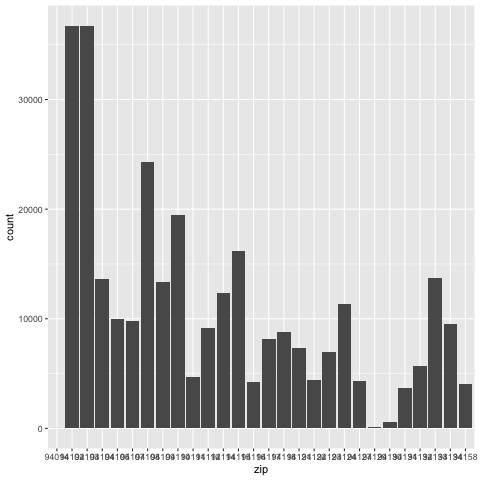

In [69]:
%%R
ggplot() + geom_bar(data=police_zip_violence, aes(x=zip))